## Methods for viewing bam alignments and others

In [1]:
import os, sys, io, random, subprocess, time
import string
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
from importlib import reload

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
from pyfaidx import Fasta

import pylab as plt

In [2]:
testfile = 'albania/3_S57_L001-4_R1_001.fastq.gz'
testbam = 'mapped/3_S57_L001.bam'

In [3]:
def get_fasta_names(filename):
    """Get names of fasta sequences"""

    refseq = Fasta(filename)
    return list(refseq.keys())

def get_fasta_sequence(filename, start, end, key=0):
    """Get chunk of indexed fasta sequence at start/end points"""
    
    from pyfaidx import Fasta
    refseq = Fasta(filename)
    if type(key) is int:
        chrom = list(refseq.keys())[key]
    print (chrom)
    seq = refseq[chrom][start:end].seq
    return seq

def get_chrom(bam_file):
    """Get first sequence name in a bam file"""
    
    import pysam
    samfile = pysam.AlignmentFile(bam_file, "r")
    iter=samfile.fetch(start=0,end=10)
    for read in iter:
        if read.reference_name:
            return read.reference_name        
        

In [24]:
def get_coverage(bam_file, chr, start, end):
    """Get coverage from bam file at specified region"""

    import pysam
    if bam_file is None or not os.path.exists(bam_file):
        return
    samfile = pysam.AlignmentFile(bam_file, "r")
    vals = [(pileupcolumn.pos, pileupcolumn.n) for pileupcolumn in samfile.pileup(chr, start, end)]
    df = pd.DataFrame(vals,columns=['pos','coverage'])
    df = df[(df.pos>=start) & (df.pos<=end)]
    #fill with zeroes if there is no data at ends
    if df.pos.max() < end:
        new = pd.DataFrame({'pos':range(df.pos.max(), end)})
        new['coverage'] = 0
        df = df.append(new).reset_index(drop=True)
    return df

def get_bam_aln(bam_file, chr, start, end, group=False):
    """Get all aligned reads from a sorted bam file for within the given coords"""

    import pysam
    if not os.path.exists(bam_file):
        return
    if chr is None:
        return
    if start<1:
        start=0    
    samfile = pysam.AlignmentFile(bam_file, "r")
    iter = samfile.fetch(chr, start, end)
    d=[]
    for read in iter:
        st = read.reference_start        
        d.append([read.reference_start, read.reference_end, read.cigarstring,
                  read.query_name,read.query_length,read.mapping_quality])
    df = pd.DataFrame(d,columns=['start','end','cigar','name','length','mapq'])
    if len(df) == 0:
        return pd.DataFrame()
    if group == True:
        df['counts'] = df.groupby(['start','end']).name.transform('count')
        df = df.drop_duplicates(['start','end'])
    df['y'] = 1
    bins = (end-start)/150
    if bins < 1:
        bins = 1
    xbins = pd.cut(df.start,bins=bins)
    df['y'] = df.groupby(xbins)['y'].transform(lambda x: x.cumsum())    
    return df

In [25]:
chrom=get_chrom(testbam)

In [26]:
cov = get_coverage(testbam,chrom,100,1560)

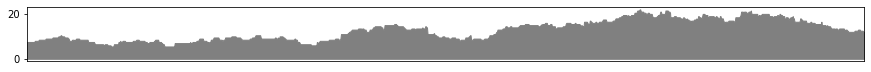

In [36]:
def plot_coverage(df, plot_width=800, plot_height=60, xaxis=True, ax=None):
    """Plot a bam coverage dataframe returned from get_coverage
    Args:
        df: dataframe of coverage data (from get_coverage)
        plot_width: width of plot
        xaxis: plot the x-axis ticks and labels
    """

    #if df is None or len(df)==0:
    #    return plot_empty(plot_width=plot_width,plot_height=plot_height)
    df['y'] = df.coverage/2
    x_range = (df.pos.min(),df.pos.max())
    top = df.coverage.max()
    if ax==None:
        fig,ax = plt.subplots(1,1,figsize=(15,1))
    ax.fill_between(df.pos,df.y,color='gray')
    ax.set_xlim(x_range)
    if xaxis==False:
        ax.get_xaxis().set_visible(False)
    return

plot_coverage(cov,xaxis=False)

0.37464022636413574


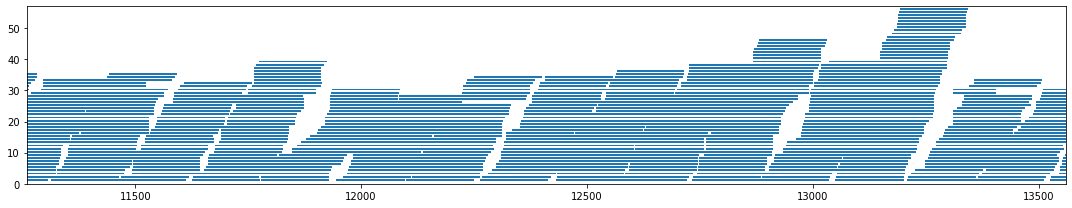

In [52]:
def plot_bam_alignment(bam_file, chr, start, end, height=1, fill_color='#459ECF', ax=None):
    """bam alignments plotter.
    Args:
        bam_file: name of a sorted bam file
        start: start of range to show
        end: end of range
    """

    h=.6#+height/plot_height
    #cover the visible range from start-end
    o = (end-start)/2
    #get reads in range into a dataframe
    df = get_bam_aln(bam_file, chr, start-o, end+o)
    df['x'] = df.start+df.length/2
    #set colors by quality
    df['color'] = df.apply(lambda x: 'red' if x.mapq==0 else fill_color ,1)
    df['span'] = df.apply(lambda x: str(x.start)+':'+str(x.end),1)
    #print (df[:3])
    if ax==None:
        fig,ax = plt.subplots(1,1,figsize=(15,3))
    from matplotlib.collections import PatchCollection
    patches=[]
    for i,r in df.iterrows():
        rect = plt.Rectangle((r.x, r.y),
                              r.length,
                              h, facecolor=r.color,
                              edgecolor='black', linewidth=0)
        #ax.add_patch(rect)
        patches.append(rect)
                                                    
    ax.add_collection(PatchCollection(patches))
    ax.set_ylim(0,df.y.max())
    ax.set_xlim(start, end)
    plt.tight_layout()
    return

st=time.time()
plot_bam_alignment(testbam,chrom,11260,13560)
print (time.time()-st)